In [1]:
""" This code is modified version of the code from
    https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch
    to fit the optimization problem.
"""
#!/usr/bin/env python
# coding: utf-8

# 1. Loading


# import warnings
# from itertools import accumulate
from typing import Dict #, List
from ax.utils.notebook.plotting import render #, init_notebook_plotting
from ax.service.managed_loop import optimize
from ax.plot.trace import optimization_trace_single_method
from ax.plot.contour import plot_contour
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")


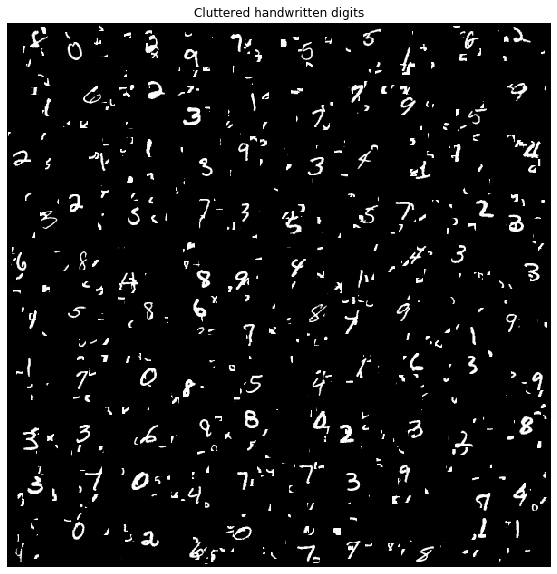

In [2]:

# 2. Load data and minding to be smaller.
NUM_EPOCHS = 15
BATCH_SIZE = 256
DIM = 60
NUM_CLASSES = 10
MNIST_C = "mnist_cluttered_60x60_6distortions.npz"


def load_data():
    """ Load the npz-map and sort the data in a train, valid and test datset.

    Args:
        None
    Returns:
        dict: A dictionary with the data sorted. """

    data_pictures = np.load(MNIST_C)
    x_train, y_train = data_pictures['x_train'], np.argmax(data_pictures['y_train'], axis=-1)
    x_valid, y_valid = data_pictures['x_valid'], np.argmax(data_pictures['y_valid'], axis=-1)
    x_test, y_test = data_pictures['x_test'], np.argmax(data_pictures['y_test'], axis=-1)

    # reshape for convolutions
    x_train = x_train.reshape((x_train.shape[0], 1, DIM, DIM))
    x_valid = x_valid.reshape((x_valid.shape[0], 1, DIM, DIM))
    x_test = x_test.reshape((x_test.shape[0], 1, DIM, DIM))

#    print("Train samples:", x_train.shape)
#    print("Validation samples:", x_valid.shape)
#    print("Test samples:", x_test.shape)

    return dict(x_train=np.asarray(x_train, dtype='float32'), \
                y_train=y_train.astype('int32'),              \
                x_valid=np.asarray(x_valid, dtype='float32'), \
                y_valid=y_valid.astype('int32'),              \
                x_test=np.asarray(x_test, dtype='float32'),   \
                y_test=y_test.astype('int32'),                \
                num_examples_train=x_train.shape[0],          \
                num_examples_valid=x_valid.shape[0],          \
                num_examples_test=x_test.shape[0],            \
                input_height=x_train.shape[2],                \
                input_width=x_train.shape[3],                 \
                output_dim=10,)


DATA = load_data()

IDX = 0
CANVAS = np.zeros((DIM*NUM_CLASSES, NUM_CLASSES*DIM))
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        CANVAS[i*DIM:(i+1)*DIM, j*DIM:(j+1) *
               DIM] = DATA['x_train'][IDX].reshape((DIM, DIM))
        IDX += 1
plt.figure(figsize=(10, 10))
plt.imshow(CANVAS, cmap='gray')
plt.title('Cluttered handwritten digits')
plt.axis('off')
plt.show()

In [3]:


# 3. Defining the Convolutional Neural Network

class Net(nn.Module):
    """ Neural Network """
    def __init__(self, input_channels=1, input_height=60, \
            input_width=60, num_classes=10, num_zoom=3):
        super(Net, self).__init__()
        self.input_channels = input_channels
        self.input_height = input_height
        self.input_width = input_width
        self.num_classes = num_classes
        self.num_zoom = num_zoom

        # Spatial transformer localization-network
        # nn.Sequential http://pytorch.org/docs/master/nn.html#torch.nn.Sequential
        #   A sequential container.
        #   Modules will be added to it in the order they are passed in the constructor.
        self.localization = nn.Sequential(nn.Conv2d(in_channels=input_channels,\
            out_channels=8, kernel_size=7, padding=3), nn.MaxPool2d(kernel_size=2,\
            stride=2), nn.ReLU(inplace=True), nn.Conv2d(in_channels=8,\
            out_channels=10, kernel_size=5, padding=2), nn.MaxPool2d(kernel_size=2,\
            stride=2), nn.ReLU(inplace=True))

        # Regressor for the 3 * 2 affine matrix that we use
        # to make the bilinear interpolation for the spatial transformer
        self.fc_loc = nn.Sequential(nn.Linear(in_features=10 * input_height//4 * input_width//4, \
            out_features=32, bias=True), nn.ReLU(inplace=True), nn.Linear(in_features=32,        \
            out_features=3 * 2, bias=True))

        # Initialize the weights/bias with identity transformation
        # see the article for a definition and explanation for this
        self.fc_loc[2].weight.data.fill_(0)
        self.fc_loc[2].bias.data = torch.FloatTensor([1, 0, 0, 0, 1, 0])

        # The classification network based on the transformed (cropped) image
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=16, kernel_size=5, \
            padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        self.conv2_drop = nn.Dropout2d()

        # fully connected output layers
        self.fc1_features = 32 * input_height//num_zoom//4 * input_width//num_zoom//4
        self.fc1 = nn.Linear(in_features=self.fc1_features, out_features=50)
        self.fc2 = nn.Linear(in_features=50, out_features=num_classes)

    # Spatial transformer network forward function
    def stn(self, x_picture):
        """ Spatial Transformer Network """
        # creates distributed embeddings of the image with the location network.
        x_s = self.localization(x_picture)
        x_s = x_s.view(-1, 10 * self.input_height//4 * self.input_width//4)
        # project from distributed embeddings to bilinear interpolation space
        theta = self.fc_loc(x_s)
        theta = theta.view(-1, 2, 3)

        # define the output size of the cropped tensor
        # notice that we divide the height and width with the amount of zoom
        output_size = torch.Size((x_picture.size()[0], x_picture.size()[1], \
            x_picture.size()[2]//self.num_zoom, x_picture.size()[3]//self.num_zoom))
        # magic pytorch functions that are used for transformer networks
        # http://pytorch.org/docs/master/nn.html#torch.nn.functional.affine_grid
        grid = F.affine_grid(theta, output_size)
        # http://pytorch.org/docs/master/nn.html#torch.nn.functional.grid_sample
        result = F.grid_sample(x_picture, grid)
        return result

    def forward(self, x_picture):
        # transform the input
        x_picture = self.stn(x_picture)
        # save transformation
        l_trans1 = Variable(x_picture.data)

        # Perform the usual forward pass
        x_picture = F.relu(F.max_pool2d(self.conv1(x_picture), 2))
        x_picture = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x_picture)), 2))
        x_picture = x_picture.view(-1, self.fc1_features)
        x_picture = F.relu(self.fc1(x_picture))
        # note use of Functional.dropout, where training must be explicitly defined (default: False)
        x_picture = F.dropout(x_picture, training=self.training)
        x_picture = self.fc2(x_picture)
        # return output and batch of bilinear interpolated images
        return F.log_softmax(x_picture, dim=1), l_trans1


print(Net())


Net(
  (localization): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(8, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
  )
  (fc_loc): Sequential(
    (0): Linear(in_features=2250, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=800, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [4]:
NET = Net()

# test forward pass on dummy data
TEST_EXAMPLE = np.random.normal(0, 1, (45, 1, 60, 60)).astype('float32')
TEST_EXAMPLE = Variable(torch.from_numpy(TEST_EXAMPLE))
if torch.cuda.is_available():
    TEST_EXAMPLE = TEST_EXAMPLE.cuda()
output = NET(TEST_EXAMPLE)
print([TEST_EXAMPLE.size() for TEST_EXAMPLE in output])


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if torch.cuda.is_available():
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if torch.cuda.is_available():
        return x.cpu().data.numpy()

    return x.data.numpy()


[torch.Size([45, 10]), torch.Size([45, 1, 20, 20])]


In [5]:

def train_bayesian_optimization(net: torch.nn.Module, input_picture: DATA,\
        label_picture: DATA, parameters: Dict[str, float],) -> nn.Module:
    """ Train the network on provided data set to find the optimzed hyperparamter settings.
    Args:
        net: initialized neural network
        Input: The image
        Label: Th label to the respective image
        parameters: dictionary containing parameters to be passed to the optimizer.
            - lr: default (0.001)
            - momentum: default (0.0)
            - weight_decay: default (0.0)
            - num_epochs: default (1)
    Returns:
        nn.Module: trained Network. """
  
    # Define the data
    x_train = input_picture
    y_train = label_picture

    # Initilize network
    net.train()

    # Define the hyperparameters
    criteron = F.cross_entropy
    optimizer = optim.Adam(net.parameters(),\
                          lr=parameters.get("lr", 0.001))
    scheduler = optim.lr_scheduler.StepLR(optimizer,\
                        step_size=int(parameters.get("step_size", 20)),\
                        gamma=parameters.get("gamma", 1.0),)
    
    num_epochs = parameters.get("num_epochs", 1)

    # Get the number of samples and batches before starting trainging the network
    num_samples = x_train.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))

    for _ in range(num_epochs):
        for i in range(num_batches):
            idx = range(i*BATCH_SIZE, np.minimum((i+1)* BATCH_SIZE, num_samples))
            x_batch_tr = get_variable(Variable(torch.from_numpy(x_train[idx])))
            y_batch_tr = get_variable(Variable(torch.from_numpy(y_train[idx]).long()))
            
            optimizer.zero_grad()
            output, _ = net(x_batch_tr)
            loss = criteron(output, y_batch_tr)
            loss.backward()
            optimizer.step()
            scheduler.step()
#    pass
    return net


def eval_bayesian_optimization(net: torch.nn.Module, input_picture: DATA,\
                                label_picture: DATA, ) -> float:
    """ Compute classification accuracy on provided dataset to find the optimzed hyperparamter
        settings.
    Args:
        net: trained neural network
        Input: The image
        Label: Th label to the respective image
    Returns:
        float: classification accuracy """
  
    # Define the data
    x_valid = input_picture
    y_valid = label_picture

    # Pre-locating memory
    correct = 0
    
    # Get the number of samples and batches before testing the network
    num_samples = x_valid.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    net.eval()

    with torch.no_grad():
        for i in range(num_batches):

            idx = range(i*BATCH_SIZE, np.minimum((i+1)
                                                 * BATCH_SIZE, num_samples))
            x_batch_val = get_variable(Variable(torch.from_numpy(x_valid[idx])))
            y_batch_val = get_variable(Variable(torch.from_numpy(y_valid[idx]).long()))
            output, transformation = net(x_batch_val)
            _, predicted = torch.max(output.data, 1)

            correct += (predicted == y_batch_val).float().mean()
    # Calculating the accuracy
#    pass
    return float(correct/num_batches)



In [6]:

def evaluate_hyperparameters(parameterization):
    """ Train and evaluate the network to find the best parameters
    Args:
        parameterization: The hyperparameters that should be evaluated
    Returns:
        float: classification accuracy """
    net = Net()
    net = train_bayesian_optimization(net=net, input_picture=DATA['x_train'],\
                   label_picture=DATA['y_train'], parameters=parameterization,)
#    pass
    return eval_bayesian_optimization(net=net, input_picture=DATA['x_valid'],\
                                      label_picture=DATA['y_valid'],)


In [ ]:


BEST_PARAMETERS, VALUES, EXPERIMENT, MODEL = optimize(parameters=[{"name": "lr",\
    "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},]\
    , evaluation_function=evaluate_hyperparameters,\
    objective_name='accuracy',)

[INFO 03-30 12:14:32] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 arms, GPEI for subsequent arms], generated 0 arm(s) so far). Iterations after 5 will take longer to generate due to model-fitting.
[INFO 03-30 12:14:32] ax.service.managed_loop: Started full optimization with 20 steps.
[INFO 03-30 12:14:32] ax.service.managed_loop: Running optimization trial 1...
[INFO 03-30 12:16:15] ax.service.managed_loop: Running optimization trial 2...
[INFO 03-30 12:17:57] ax.service.managed_loop: Running optimization trial 3...
[INFO 03-30 12:19:42] ax.service.managed_loop: Running optimization trial 4...


In [ ]:


# Saving the results from the optimization
BE = []
ME = []
CO = []

MEANS, COVARIANCES = VALUES

BE.append(BEST_PARAMETERS)
ME.append(MEANS)
CO.append(COVARIANCES)

# Printing the results of the hyperparamter optimization
print(BEST_PARAMETERS)
print(MEANS, COVARIANCES)

# Findin the best hyperparameter for training the network

DATA1 = EXPERIMENT.fetch_data()
DF = DATA1.df
BEST_ARM_NAME = DF.arm_name[DF['mean'] == DF['mean'].max()].values[0]
BEST_ARM = EXPERIMENT.arms_by_name[BEST_ARM_NAME]
BEST_ARM



In [ ]:
# class best_arm1:
#    parameters = {}
#    parameters["lr"] = 0.001
#    parameters["momentum"] = 0.001
#    parameters["weight_decay"] = 0.001
#best_arm = best_arm1()


#render(plot_contour(model=MODEL, param_x='lr',
#                    param_y='weight_decay', metric_name='accuracy'))


#BEST_OBJECTIVES = np.array([[trial.objective_mean*100 for trial in EXPERIMENT.trials.values()]])
#BEST_OBJECTIVE_PLOT = optimization_trace_single_method(y=np.maximum.accumulate(\
#    BEST_OBJECTIVES, axis=1), title="Model performance vs. # of iterations",\
#    ylabel="Classification Accuracy, %",)

#render(BEST_OBJECTIVE_PLOT)


In [ ]:
LR = BEST_ARM.parameters.get("lr", 0.001)
LR = 0.0031483721541891193
LR = 0.0013711634546194602
LR = 0.005365228989326679
LR = 0.006635871831316232

In [5]:

LR = 0.006635871831316232

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = LR)

def train_epoch(input_picture: DATA, label_picture: DATA,) -> float:
    """ Train the network with the optimized hyperparamters.
    Args:
        Input: The image
        Label: The label to the respective image
    Returns:
        float: the mean cost and the classification accuracy """
    # Define the data
    x_valid = input_picture
    y_valid = label_picture

    # Initilize network
    net.train()

    # Pre-locating memory
    costs = []
    correct = 0

    # Get the number of samples and batches before testing the network
    num_samples = x_valid.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))

    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        x_batch_tr = get_variable(Variable(torch.from_numpy(x_valid[idx])))
        y_batch_tr = get_variable(Variable(torch.from_numpy(y_valid[idx]).long()))

        optimizer.zero_grad()
        output, _ = net(x_batch_tr)
        batch_loss = criterion(output, y_batch_tr)

        batch_loss.backward()
        optimizer.step()

        costs.append(get_numpy(batch_loss))
        preds = np.argmax(get_numpy(output), axis=-1)
        correct += np.sum(get_numpy(y_batch_tr) == preds)
    #   pass
    return np.mean(costs), correct / float(num_samples)


def eval_epoch(input_picture: DATA, label_picture: DATA,) -> float:
    """ Compute classification accuracy on provided dataset to the optimized network.

    Args:
        Input: The image
        Label: Th label to the respective image
    Returns:
        float: classification accuracy """
    # Define the data
    x_valid = input_picture
    y_valid = label_picture

    # Pre-locating memory
    pred_list = []

    # Get the number of samples and batches before testing the network
    num_samples = x_valid.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    net.eval()
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        x_batch_val = get_variable(Variable(torch.from_numpy(x_valid[idx])))
        output, _ = net(x_batch_val)
        pred_list.append(get_numpy(output))

    # Calculating the accuracy
    preds_result = np.concatenate(pred_list, axis=0)
    preds_result = np.argmax(preds_result, axis=-1)
    accuracy_results = np.mean(preds_result == y_valid)

#    pass
    return accuracy_results



In [ ]:

# Saving the results from the optimization
VALID_ACCS, TRAIN_ACCS, TEST_ACCS, TRAIN_COSTS = [], [], [], []

N = 0
while N < NUM_EPOCHS:
    N += 1
    try:
        print("Epoch %d:" % N)

        TRAIN_COST, TRAIN_ACC = train_epoch(input_picture=DATA['x_train'],\
                                            label_picture=DATA['y_train'],)
        VALID_ACC = eval_epoch(input_picture=DATA['x_valid'],\
                               label_picture=DATA['y_valid'],)
        TEST_ACC = eval_epoch(input_picture=DATA['x_test'],\
                              label_picture=DATA['y_test'],)
        VALID_ACCS += [VALID_ACC]
        TEST_ACCS += [TEST_ACC]
        TRAIN_ACCS += [TRAIN_ACC]
        TRAIN_COSTS += [TRAIN_COST]
        
        print("train cost {0:.2}, train acc {1:.2}, val acc {2:.2}, test acc {3:.2}".format(
            TRAIN_COST, TRAIN_ACC, VALID_ACC, TEST_ACC))

    except KeyboardInterrupt:
        print('\nKeyboardInterrupt')
        break


Epoch 1:
train cost 2.3, train acc 0.11, val acc 0.11, test acc 0.11
Epoch 2:


In [ ]:


np.save('HO_Train_acc_4', TRAIN_ACCS)
np.save('HO_Valid_acc_4', VALID_ACCS)
np.save('HO_Test_acc_4', TEST_ACCS)
np.save('HO_Train_cost_4', TRAIN_COSTS)



plt.figure(figsize=(9, 9))
plt.plot(np.array(TRAIN_ACCS), label='Training Error')
plt.plot(np.array(VALID_ACCS), label='Validation Error')
plt.plot(np.array(TEST_ACCS), label='Test Error')

plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Error', fontsize=20)
plt.show()